In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

from labellines import labelLine, labelLines
%pylab inline

ImportError: No module named 'labellines'

### Расчет

Некоторые константы

In [39]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 7.246 #энергия отрыва нейтрона

total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [40]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [41]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [42]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [43]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [44]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/Z_54.ocr.xls', 
                                    parse_cols="A,B", decimal='.')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
p       48 non-null float64
F0L0    48 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [45]:
Fermi_func_new_data.head()

,p,F0L0
0,0.1,68.550
1,0.2,34.627
2,0.3,23.465
3,0.4,17.995
4,0.5,14.807


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [46]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['p'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### BS05_OP flux

In [47]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [48]:
BP98_Be = 4.80e9
BP98_pp = 5.94e10
BP98_pep = 1.39e8
BP98_hep = 2.10e3
BP98_B = 5.15e6 
BP98_N = 6.05e8
BP98_0 = 5.32e8
BP98_F = 6.33e6

In [49]:
BP98_OPAL92_Be = 4.94e9
BP98_OPAL92_pp = 5.92e10
BP98_OPAL92_pep = 1.39e8
BP98_OPAL92_hep = 2.08e3
BP98_OPAL92_B = 5.44e6 
BP98_OPAL92_N = 6.25e8
BP98_OPAL92_0 = 5.52e8
BP98_OPAL92_F = 6.59e6

In [50]:
#B16-GS98 - high metallicity
B16_GS98_Be = 4.93e9
B16_GS98_pp = 5.98e10
B16_GS98_pep = 1.44e8
B16_GS98_hep = 7.98e3
B16_GS98_B = 5.46e6 
B16_GS98_N = 2.78e8
B16_GS98_0 = 2.05e8
B16_GS98_F = 5.29e6

In [51]:
#B16-AGSS09met - low metallicity
B16_AGSS09met_Be = 4.50e9
B16_AGSS09met_pp = 6.03e10
B16_AGSS09met_pep = 1.46e8
B16_AGSS09met_hep = 8.25e3
B16_AGSS09met_B = 4.50e6 
B16_AGSS09met_N = 2.04e8
B16_AGSS09met_0 = 1.44e8
B16_AGSS09met_F = 3.26e6

In [52]:
#fluxes_df = pd.DataFrame()

In [53]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [54]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [55]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

BP98_flux = return_flux(pp_ampl=BP98_pp, 
                          hep_ampl=BP98_hep,
                          B_ampl=BP98_B,
                          N_ampl=BP98_N,
                          O_ampl=BP98_0,
                          F_ampl=BP98_F)

BP98_OPAL92_flux = return_flux(pp_ampl=BP98_OPAL92_pp, 
                          hep_ampl=BP98_OPAL92_hep,
                          B_ampl=BP98_OPAL92_B,
                          N_ampl=BP98_OPAL92_N,
                          O_ampl=BP98_OPAL92_0,
                          F_ampl=BP98_OPAL92_F)

B16_GS98_flux = return_flux(pp_ampl=B16_GS98_pp, 
                          hep_ampl=B16_GS98_hep,
                          B_ampl=B16_GS98_B,
                          N_ampl=B16_GS98_N,
                          O_ampl=B16_GS98_0,
                          F_ampl=B16_GS98_F)

B16_AGSS09met_flux = return_flux(pp_ampl=B16_AGSS09met_pp, 
                          hep_ampl=B16_AGSS09met_hep,
                          B_ampl=B16_AGSS09met_B,
                          N_ampl=B16_AGSS09met_N,
                          O_ampl=B16_AGSS09met_0,
                          F_ampl=B16_AGSS09met_F)

In [56]:
#!pip install matplotlib-label-lines

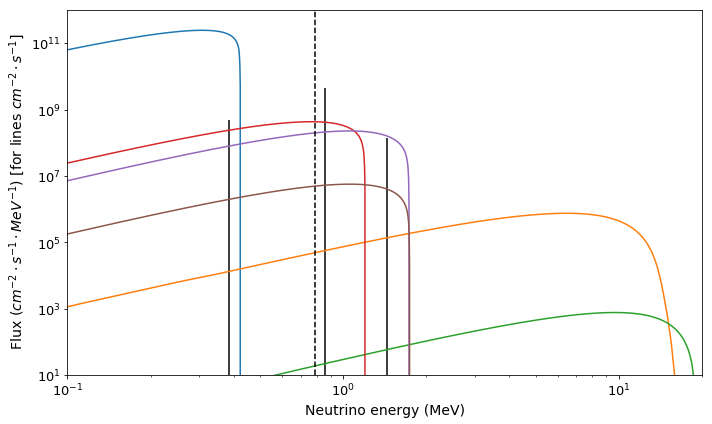

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)

ax.plot(Energy_all_fluxes, BS05OP_flux['pp'], label='pp')
ax.plot(Energy_all_fluxes, BS05OP_flux['b8'], label='8B')
ax.plot(Energy_all_fluxes, BS05OP_flux['hep'], label='hep')
ax.plot(Energy_all_fluxes, BS05OP_flux['n13'], label='13N')
ax.plot(Energy_all_fluxes, BS05OP_flux['o15'], label='15O')
ax.plot(Energy_all_fluxes, BS05OP_flux['f17'], label='17F')

ax.axvline(Q_EC_127Xe+0.125, c='k', ls='--')
#ax.text(Q_EC_127Xe+0.05, 10**11, 'Q=232.6 KeV', rotation=90, fontsize=12)

ax.vlines(pep_en, 0, BS05OP_pep, label='pep')
ax.vlines(Be384_en, 0, BS05OP_Be*0.103, label='7Be 384 KeV')
ax.vlines(Be862_en, 0, BS05OP_Be*(1-0.103), label='7Be 862 KeV')

ax.set_xlabel('Neutrino energy (MeV)', fontsize=14)
ax.set_ylabel(' Flux ($cm^{-2}\cdot s^{-1}\cdot MeV^{-1}$) [for lines $cm^{-2}\cdot s^{-1}$]', fontsize=14)

ax.set_yscale('log')
ax.set_xscale('log')
my_yticks = [ 10**(1), 10**(2), 10**(3), 10**(4), 10**(5), 10**(6), 10**(7), 10**(8),
            10**(9), 10**(10), 10**(11), 10**(12)]
#ax.set_yticks(my_yticks)

#ax.set_xticks(np.arange(0,21,1))

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(True)

ax.get_yaxis().set_major_formatter(formatter)

def myticks(x,pos):
    if x == 0: return "$0$"
    exponent = int(np.log10(x))
    return r"$10^{{ {:2d} }}$".format(exponent)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(myticks))

#labelLines(plt.gca().get_lines(), zorder=2.5)

#my_yticks_str = [str(elem) for elem in my_yticks]
#ax.set_yticklabels(my_yticks_str)
#ax.set_xticks(np.arange(0,21,1))

ax.set_ylim(10**(1), 10**(12))
ax.set_xlim(10**(-1), 20)
#ax.legend(fontsize=13, loc='upper right')
fig.tight_layout()
fig.savefig('solar_flux_for_127I.png', format='png', dpi=500)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [58]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [59]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [60]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

### Расчет сечения с учетом графика из статьи 1999 года


In [61]:
best_fit = pd.read_excel('127Xe_gauss.xls')
best_fit.head()
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

,"Ex, MeV",y
0,0.350987,0.000603
1,0.434621,0.000786
2,0.482412,0.000911
3,0.589942,0.001261
4,0.733315,0.001911


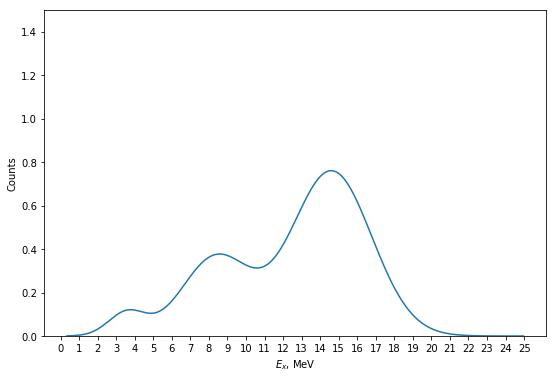

In [62]:
plt.figure(figsize=(9,6))
plt.plot(best_fit['Ex, MeV'].values, best_fit['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,1.5)
plt.xticks(np.arange(0,26,1))
plt.show()

In [63]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [64]:
trapz(best_fit['y'].values, best_fit['Ex, MeV'].values)

6.057219427825755

(0, 20)

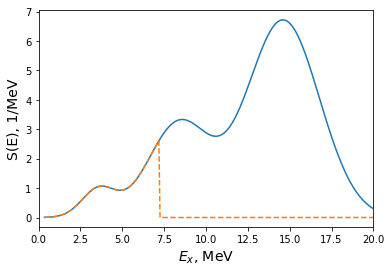

In [65]:
y = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['Ex, MeV'].values) \
* total_GT

#y_best_fit_border = border_func(best_fit['x'].values, y_best_fit, S_n)
y_border = border_func(best_fit['Ex, MeV'].values, y, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(best_fit['Ex, MeV'].values, y_border, ls='--')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)

In [66]:
total_GT

53.54

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [67]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [68]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [69]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

сечение без Sn

In [70]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_no_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y, 200) for p in p_list]

sigma_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

сечение с Sn

In [71]:
sigma_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y_border, 200) for p in p_list]

sigma_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

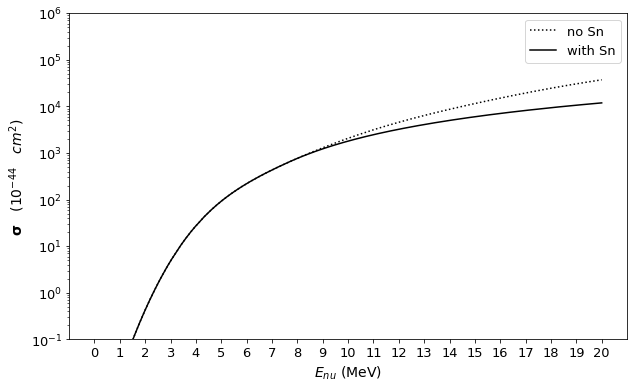

In [72]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

SNU с Sn

In [73]:
rate_calc(sigma_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.3082293572815671,
 'Total': 42.11957637706907,
 'b8': 41.435691794689895,
 'f17': 0.0017768671739810291,
 'hep': 0.17715348581421464,
 'n13': 0.016793521200135397,
 'name': 'test1',
 'o15': 0.06981219979904106,
 'pep': 0.1101191511102414,
 'pp': 0.0}

SNU без Sn

In [74]:
rate_calc(sigma_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.3082293572815671,
 'Total': 49.773405726857405,
 'b8': 48.979480264850515,
 'f17': 0.0017768671739810291,
 'hep': 0.2871943654419273,
 'n13': 0.016793521200135397,
 'name': 'test1',
 'o15': 0.06981219979904106,
 'pep': 0.1101191511102414,
 'pp': 0.0}

### данные из графика BGT

In [75]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

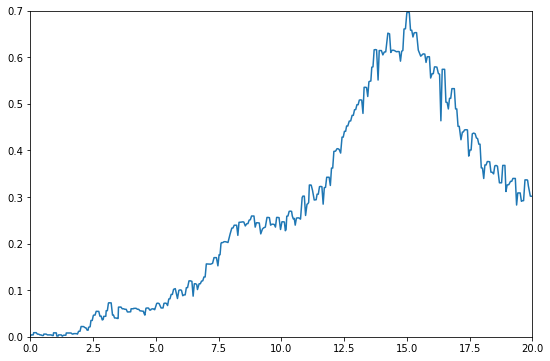

In [76]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [77]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

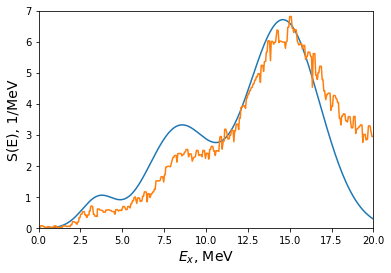

In [78]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(bgt['x'].values, y_bgt, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)


In [79]:
sigma_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt, 200) for p in p_list]

sigma_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [80]:
sigma_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, 200) for p in p_list]

sigma_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

### BS05OP

In [81]:
rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 30.30333248680226,
 'b8': 25.70856975850676,
 'f17': 0.014034302708537179,
 'hep': 0.10864040126664977,
 'n13': 0.16693835671447224,
 'name': 'test1',
 'o15': 0.553607016385992,
 'pep': 0.8302972050993707,
 'pp': 0.0}

In [82]:
rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 35.60079465787901,
 'b8': 30.922363293771188,
 'f17': 0.014034302708537179,
 'hep': 0.1923090370789622,
 'n13': 0.16693835671447224,
 'name': 'test1',
 'o15': 0.553607016385992,
 'pep': 0.8302972050993707,
 'pp': 0.0}

### BP98

In [83]:
rate_calc(sigma_bgt_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.8971029217723765,
 'Total': 28.615593468275,
 'b8': 23.268740642585207,
 'f17': 0.015211838381000056,
 'hep': 0.028769841445140543,
 'n13': 0.3289827550887808,
 'name': 'test1',
 'o15': 1.264029754151707,
 'pep': 0.8127557148507923,
 'pp': 0.0}

In [84]:
rate_calc(sigma_bgt_no_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.8971029217723765,
 'Total': 33.35673747687293,
 'b8': 27.987727761497652,
 'f17': 0.015211838381000056,
 'hep': 0.0509267311306205,
 'n13': 0.3289827550887808,
 'name': 'test1',
 'o15': 1.264029754151707,
 'pep': 0.8127557148507923,
 'pp': 0.0}

### BP98 OPAL92

In [85]:
rate_calc(sigma_bgt_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.9816017569907376,
 'Total': 30.06911709768898,
 'b8': 24.57901924187641,
 'f17': 0.015836653227613014,
 'hep': 0.028495842955186822,
 'n13': 0.3398582180669223,
 'name': 'test1',
 'o15': 1.31154966972132,
 'pep': 0.8127557148507923,
 'pp': 0.0}

In [86]:
rate_calc(sigma_bgt_no_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.9816017569907376,
 'Total': 35.075779460034475,
 'b8': 29.563735732533434,
 'f17': 0.015836653227613014,
 'hep': 0.05044171464366222,
 'n13': 0.3398582180669223,
 'name': 'test1',
 'o15': 1.31154966972132,
 'pep': 0.8127557148507923,
 'pp': 0.0}

### B16-GS98 (hight metallicity)

In [87]:
rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_GS98_pep, func_Be_ampl=B16_GS98_Be,)

{'Be': 2.9755661259037116,
 'Total': 29.2472269875131,
 'b8': 24.669383283206844,
 'f17': 0.01271257899454823,
 'hep': 0.10932539749153407,
 'n13': 0.15116893539616705,
 'name': 'test1',
 'o15': 0.48707913458853364,
 'pep': 0.8419915319317562,
 'pp': 0.0}

###  B16-AGSS09met (low metallicity)

In [88]:
rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_AGSS09met_pep, func_Be_ampl=B16_AGSS09met_Be,)

{'Be': 2.7160339891616028,
 'Total': 24.475560855779122,
 'b8': 20.331909299346297,
 'f17': 0.0078342169229163,
 'hep': 0.11302437710590928,
 'n13': 0.11092972237704345,
 'name': 'test1',
 'o15': 0.34214339210121386,
 'pep': 0.8536858587641417,
 'pp': 0.0}

In [93]:
no11 = rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP with neutron separation')

no22 = rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP without neutron separation')

no33 = rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-GS98 (hight metallicity) with neutron separation')

no44 = rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-AGSS09met (low metallicity) with neutron separation')



In [95]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,BS05OP with neutron separation,2.921,0.014,25.709,0.167,0.83,0.554,0.109,0.0,30.303
1,BS05OP without neutron separation,2.921,0.014,30.922,0.167,0.83,0.554,0.192,0.0,35.601
2,B16-GS98 (hight metallicity) with neutron sepa...,2.921,0.013,24.669,0.151,0.83,0.487,0.109,0.0,29.181
3,B16-AGSS09met (low metallicity) with neutron s...,2.921,0.008,20.332,0.111,0.83,0.342,0.113,0.0,24.657


In [96]:
output_table0.to_excel('models_comparison.xls')

## Матричные элементы от ЮС

In [227]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = 2*np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

82.97

In [228]:
for i in Mn: print(i)

0.005
0.005
0.02
0.02
0.04
0.2
0.02
0.4
2.4
61.6
1.0
1.6
1.0
2.06
12.6


In [229]:
def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Ex = np.arange(0,40,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [230]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

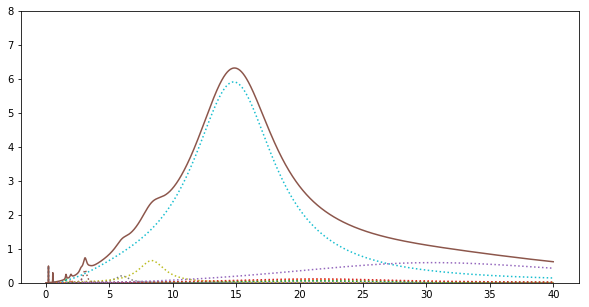

In [231]:
plt.figure(figsize=(10,5))
plt.ylim(0,8)
for elem in plots:
    plt.plot(Ex, elem, ls=':')
plt.plot(Ex, summ)
plt.show()

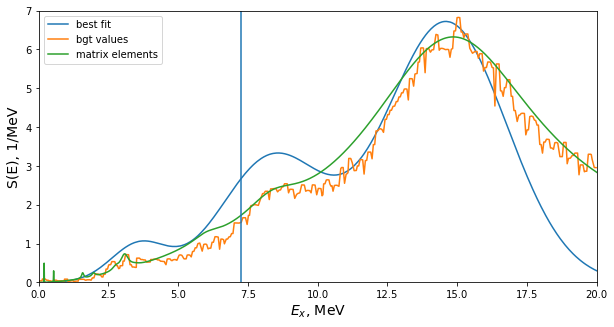

In [232]:
plt.figure(figsize=(10,5))
plt.plot(best_fit['Ex, MeV'].values, y, label='best fit')
plt.plot(bgt['x'].values, y_bgt, label='bgt values')
plt.plot(Ex, summ, label='matrix elements')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.axvline(S_n)
plt.xlim(0,20)
plt.ylim(0,7)
plt.legend()
plt.show()

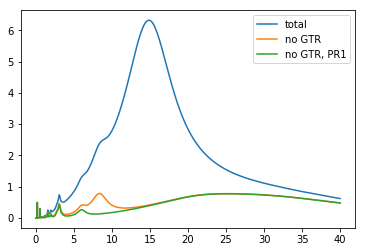

In [233]:
summ_border = border_func(Ex, summ, S_n)
summ_noGTR = summ - plots[9]
summ_noGTR_border = border_func(Ex, summ_noGTR, S_n)
summ_noGTR_PR1 = summ_noGTR - plots[8]
summ_noGTR_PR1_border = border_func(Ex, summ_noGTR_PR1, S_n)

plt.plot(Ex, summ, label='total')
plt.plot(Ex, summ_noGTR, label='no GTR')
plt.plot(Ex, summ_noGTR_PR1, label='no GTR, PR1')
plt.legend()
plt.show()

### total

In [234]:
sigma_matr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ, 200) for p in p_list]

sigma_matr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_border, 200) for p in p_list]

sigma_matr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [235]:
### BS05OP
rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5520965032485099,
 'Total': 30.88770833211092,
 'b8': 29.648240259524307,
 'f17': 0.004946369547638845,
 'hep': 0.1285154951315364,
 'n13': 0.04149181942967412,
 'name': 'test1',
 'o15': 0.19461062158959183,
 'pep': 0.31780726363965894,
 'pp': 0.0}

In [236]:
rate_calc(sigma_matr_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5520965032485099,
 'Total': 36.424556428590456,
 'b8': 35.09475511224902,
 'f17': 0.004946369547638845,
 'hep': 0.21884873888637188,
 'n13': 0.04149181942967412,
 'name': 'test1',
 'o15': 0.19461062158959183,
 'pep': 0.31780726363965894,
 'pp': 0.0}

### no GTR

In [237]:
sigma_matr_noGTR_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR, 200) for p in p_list]

sigma_matr_noGTR_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_border, 200) for p in p_list]

sigma_matr_noGTR_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                         fp=sigma_matr_noGTR_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [238]:
### BS05OP
rate_calc(sigma_matr_noGTR_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5351133343570651,
 'Total': 11.197901984658339,
 'b8': 10.150069699635702,
 'f17': 0.0041747850289859815,
 'hep': 0.0414999515201749,
 'n13': 0.03892787526322647,
 'name': 'test1',
 'o15': 0.16448217687501793,
 'pep': 0.26363416197816636,
 'pp': 0.0}

In [239]:
rate_calc(sigma_matr_noGTR_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5351133343570651,
 'Total': 12.730907444697582,
 'b8': 11.66383194950737,
 'f17': 0.0041747850289859815,
 'hep': 0.06074316168775053,
 'n13': 0.03892787526322647,
 'name': 'test1',
 'o15': 0.16448217687501793,
 'pep': 0.26363416197816636,
 'pp': 0.0}

### no GTR no PR1

In [240]:
sigma_matr_noGTR_noPR1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1, 200) for p in p_list]

sigma_matr_noGTR_noPR1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_noPR1_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_noPR1_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1_border, 200) for p in p_list]

sigma_matr_noGTR_noPR1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                   fp=sigma_matr_noGTR_noPR1_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [241]:
### BS05OP
rate_calc(sigma_matr_noGTR_noPR1_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5288827487276476,
 'Total': 8.106908095937218,
 'b8': 7.110437407263947,
 'f17': 0.003901488427010761,
 'hep': 0.02752729631417256,
 'n13': 0.03798761847188926,
 'name': 'test1',
 'o15': 0.15380456598006217,
 'pep': 0.24436697075248917,
 'pp': 0.0}

In [242]:
rate_calc(sigma_matr_noGTR_noPR1_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.5288827487276476,
 'Total': 8.438681087834082,
 'b8': 7.436838380762764,
 'f17': 0.003901488427010761,
 'hep': 0.03289931471221812,
 'n13': 0.03798761847188926,
 'name': 'test1',
 'o15': 0.15380456598006217,
 'pep': 0.24436697075248917,
 'pp': 0.0}

### to Lutostansky

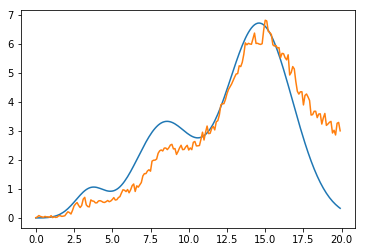

In [243]:
Ex2 = np.arange(0,20,0.1)

exp_power_func = np.interp(Ex2, best_fit['Ex, MeV'].values, y)
bgt_digit = np.interp(Ex2, bgt['x'].values, y_bgt)

plt.plot(Ex2, exp_power_func)
plt.plot(Ex2, bgt_digit)
plt.show()

In [244]:
output = pd.DataFrame(data={'Ex, MeV':Ex2,})
output['Experimetal_spec'] = exp_power_func
output['BGT_graph'] = bgt_digit
#output.to_excel('127Xe_data.xls', index=False)

In [245]:
output.head()

,"Ex, MeV",Experimetal_spec,BGT_graph
0,0.0,0.005331,0.013527
1,0.1,0.005331,0.040147
2,0.2,0.005331,0.086733
3,0.3,0.005331,0.056785
4,0.4,0.006276,0.040192


In [246]:
output.to_excel('127Xe_data.xls', index=False)

In [247]:
Et_53=[5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,
340,350,360,370,380,390,400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,1300,
1400,1500,1600,1700,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,4500,
5000,5500,6000,7000,8000,9000,10000]

In [248]:
#for i in range(100):
#    Et_53[i]=0.511+Et_53[i]/1000
Ft_53=[43.66,39.89,36.97,34.61,32.67,31.02,28.37,26.31,24.66,23.29,22.18,21.14,20.27,19.51,
18.83,18.22,16.94,15.91,15.06,14.35,13.75,13.22,12.76,12.35,11.99,11.66,11.37,11.10,10.85,
10.62,10.22,9.879,9.577,9.310,9.074,8.862,8.671,8.498,8.340,8.196,8.063,7.940,7.827,7.721,
7.622,7.530,7.443,7.362,7.385,7.212,7.144,7.079,7.017,6.958,6.902,6.848,6.797,6.748,6.701,
6.656,6.456,6.289,6.147,6.024,5.916,5.820,5.734,5.656,5.584,5.518,5.457,5.400,5.296,5.203,
5.119,5.043,4.973,4.908,4.848,4.791,4.733,4.687,4.594,4.508,4.428,4.354,4.284,4.218,4.156,
4.096,4.040,3.985,3.858,3.741,3.633,3.532,3.346,3.191,3.054,2.926]

In [249]:
#Ft_53mod=[0 for i in range(102)]
#for i in range(100):
#    Ft_53mod[i+1]=Ft_53[i]*(Et_53[i])*((Et_53[i])2-0.511**2)(0.5)
#Ft_53mod[0]=(Ft_53mod[1]-Ft_53mod[2])*5+Ft_53mod[1]
#Ft_53mod[101]=Ft_53mod[100]-(Ft_53mod[99]-Ft_53mod[100])*10

In [250]:
#Et_53mod=[0,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,55,60,65,70,75,80,85,90,95,
#100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,
#330,340,350,360,370,380,390,400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,
#1300,1400,1500,1600,1700,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,
#4500,5000,5500,6000,7000,8000,9000,10000,20000]

In [251]:
#for i in range(102):
#    Et_53mod[i]=0.511+Et_53mod[i]/1000
#def F_53(E):
#    return numpy.interp(E, Et_53, Ft_53)
#def F_53mod(E):
#    return numpy.interp(E, Et_53mod, Ft_53mod)

In [252]:
def Suslov_func(e_e):
    #input энергия электрона в кэв
    f = interp1d(x=Et_53, y=Ft_53, kind='linear', fill_value='extrapolate')
#    return np.interp(x = e_e, xp = Et_53, 
#                     fp = Ft_53)
    return f(e_e)

def Pi_e_func2(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    return np.sqrt(e_e**2 - 1)

def Janecki_func(e_e):
    #input энергия электрона в кэв
    E = 1 + e_e/511 # полная энергия электрона в единицах mc^2
    p = Pi_e_func2(E)
    return np.interp(x = p, xp = Fermi_func_new_data['p'], 
                     fp = Fermi_func_new_data['F0L0'])

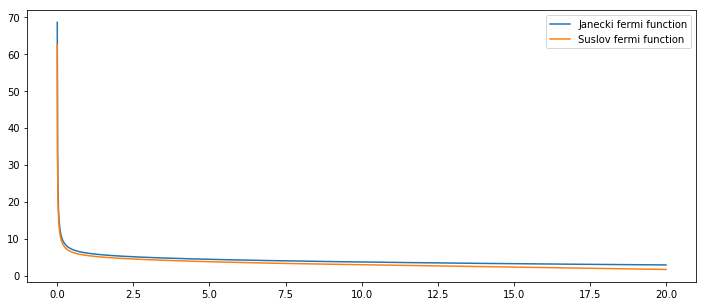

In [253]:
e_e = np.linspace(0,20, 2000) #MeV

plt.figure(figsize=(12,5))
plt.plot(e_e, Janecki_func(e_e*1000), label='Janecki fermi function')
plt.plot(e_e, Suslov_func(e_e*1000), label='Suslov fermi function')
plt.legend()
plt.show()

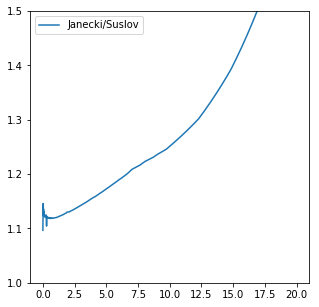

In [254]:
plt.figure(figsize=(5,5))
plt.plot(e_e, Janecki_func(e_e*1000)/ Suslov_func(e_e*1000), label='Janecki/Suslov')
plt.legend()
#plt.xlim(0,1)
plt.ylim(1,1.5)
plt.show()

### расчет c декомпозицией

In [255]:
decomp = pd.read_excel('127Xe_bgt_decomp.xls')
decomp.head(20)

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2
0,0.00,0.00000,0.013527,0.00000,0.00000,0.00000
1,0.05,0.00015,0.040147,0.00006,0.00003,0.00006
2,0.10,0.00065,0.040147,0.00026,0.00013,0.00026
3,0.15,0.00148,0.086733,0.00058,0.00030,0.00060
4,0.20,0.00264,0.086733,0.00104,0.00054,0.00106
5,0.25,0.00411,0.080341,0.00164,0.00084,0.00163
6,0.30,0.00589,0.056785,0.00237,0.00121,0.00231
7,0.35,0.00794,0.052593,0.00325,0.00163,0.00306
8,0.40,0.01022,0.040192,0.00426,0.00210,0.00386
9,0.45,0.01271,0.034657,0.00542,0.00261,0.00468


In [256]:
trapz(decomp['bgt'].values, decomp['Ex, MeV'].values),\
trapz(decomp['best_fit'].values, decomp['Ex, MeV'].values),\
trapz(decomp['gtr'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr1'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr2'].values, decomp['Ex, MeV'].values), \

(53.579161054003215,
 53.4939765,
 50.78956425,
 2.343959000000001,
 0.36045325000000006)

In [257]:
y_total_border = border_func(decomp['Ex, MeV'].values, decomp['best_fit'].values, S_n)
y_bgt_border = border_func(decomp['Ex, MeV'].values, decomp['bgt'].values, S_n)
y_gtr_border = border_func(decomp['Ex, MeV'].values, decomp['gtr'].values, S_n)
y_pr1_border = border_func(decomp['Ex, MeV'].values, decomp['pr1'].values, S_n)
y_pr2_border = border_func(decomp['Ex, MeV'].values, decomp['pr2'].values, S_n)

### bgt

In [258]:
sigma_y_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['bgt'].values, 200) for p in p_list]
sigma_y_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_bgt_no_border_temp)

sigma_y_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_bgt_border, 200) for p in p_list]
sigma_y_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_bgt_border_temp)

In [259]:
### BS05OP
rate_calc(sigma_y_bgt_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9196875534206286,
 'Total': 30.235812026636975,
 'b8': 25.637087221513045,
 'f17': 0.0140826276158515,
 'hep': 0.10837097517422577,
 'n13': 0.1665663653022177,
 'name': 'test1',
 'o15': 0.5555008380643007,
 'pep': 0.8345164455467041,
 'pp': 0.0}

In [260]:
rate_calc(sigma_y_bgt_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9196875534206286,
 'Total': 35.53502000084436,
 'b8': 30.85261522308463,
 'f17': 0.0140826276158515,
 'hep': 0.19205094781002624,
 'n13': 0.1665663653022177,
 'name': 'test1',
 'o15': 0.5555008380643007,
 'pep': 0.8345164455467041,
 'pp': 0.0}

### y_total

In [261]:
sigma_y_tot_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['best_fit'].values, 200) for p in p_list]
sigma_y_tot_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_tot_no_border_temp)

sigma_y_tot_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_total_border, 200) for p in p_list]
sigma_y_tot_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_tot_border_temp)

In [262]:
### BS05OP
rate_calc(sigma_y_tot_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.04490984222639855,
 'Total': 25.91453252732105,
 'b8': 25.560990809416296,
 'f17': 0.001745978926422203,
 'hep': 0.10920887322423205,
 'n13': 0.0064740380532171985,
 'name': 'test1',
 'o15': 0.06826300735140313,
 'pep': 0.12293997812307816,
 'pp': 0.0}

In [263]:
rate_calc(sigma_y_tot_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.04490984222639855,
 'Total': 31.143000965742043,
 'b8': 30.705926605617496,
 'f17': 0.001745978926422203,
 'hep': 0.1927415154440273,
 'n13': 0.0064740380532171985,
 'name': 'test1',
 'o15': 0.06826300735140313,
 'pep': 0.12293997812307816,
 'pp': 0.0}

### gtr

In [264]:
sigma_gtr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['gtr'].values, 200) for p in p_list]
sigma_gtr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_gtr_no_border_temp)

sigma_gtr_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_gtr_border, 200) for p in p_list]
sigma_gtr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_gtr_border_temp)

In [265]:
### BS05OP
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.027184334547858787,
 'Total': 6.867132715509342,
 'b8': 6.70361142170704,
 'f17': 0.0009648341107599838,
 'hep': 0.025637696867495337,
 'n13': 0.0038529600704730366,
 'name': 'test1',
 'o15': 0.03775982275009498,
 'pep': 0.06812164545562015,
 'pp': 0.0}

In [266]:
rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.027184334547858787,
 'Total': 8.314231722750822,
 'b8': 8.134377281619232,
 'f17': 0.0009648341107599838,
 'hep': 0.04197084419678503,
 'n13': 0.0038529600704730366,
 'name': 'test1',
 'o15': 0.03775982275009498,
 'pep': 0.06812164545562015,
 'pp': 0.0}

### pr1

In [267]:
sigma_pr1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr1'].values, 200) for p in p_list]
sigma_pr1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr1_no_border_temp)

sigma_pr1_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr1_border, 200) for p in p_list]
sigma_pr1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr1_border_temp)

In [268]:
### BS05OP
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.018085566137692285,
 'Total': 4.549623723489985,
 'b8': 4.446219411279572,
 'f17': 0.0006103240081606281,
 'hep': 0.015224163480437574,
 'n13': 0.002529500428818388,
 'name': 'test1',
 'o15': 0.02389550452839793,
 'pep': 0.04305925362690493,
 'pp': 0.0}

In [269]:
rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full-sigma_pr1_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.018085566137692285,
 'Total': 4.555549672568591,
 'b8': 4.452078281383648,
 'f17': 0.0006103240081606281,
 'hep': 0.015291242454968811,
 'n13': 0.002529500428818388,
 'name': 'test1',
 'o15': 0.02389550452839793,
 'pep': 0.04305925362690493,
 'pp': 0.0}

### pr2

In [270]:
sigma_pr2_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr2'].values, 200) for p in p_list]
sigma_pr2_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr2_no_border_temp)

sigma_pr2_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr2_border, 200) for p in p_list]
sigma_pr2_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr2_border_temp)

In [271]:
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full-sigma_pr2_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 1.4121126143407102e-17,
 'Total': 1.243622462768312e-16,
 'b8': 1.0751895139232591e-16,
 'f17': -9.219602001786023e-20,
 'hep': 1.5330554695578385e-18,
 'n13': 3.727656074857514e-20,
 'name': 'test1',
 'o15': -3.682581940964483e-18,
 'pep': 4.926614671774132e-18,
 'pp': 0.0}

In [272]:
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full-sigma_pr2_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,).keys()

dict_keys(['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'name', 'Total', 'pp'])

In [273]:
output_table = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

In [288]:
no1 = rate_calc(sigma_y_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no2 = rate_calc(sigma_y_tot_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (best_fit)')
no3 = rate_calc(sigma_matr_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,
               name='R-total (theory)')

no4 = rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full), BS05OP_flux, 
                Energy_all_fluxes, step_all_fluxes,name='R-total (best_fit) - GTR')
no5 = rate_calc(sigma_matr_noGTR_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR')

no6 = rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full-sigma_pr1_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes, name='R-total (best_fit) - GTR - PR1')
no7 = rate_calc(sigma_matr_noGTR_noPR1_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR - PR1')

In [292]:
output_table = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no1, no2, no3, no4, no5, no6, no7] : 
    output_table = output_table.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table[elem] = output_table[elem].round(3)
output_table

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),2.920,0.014,30.853,0.167,0.835,0.556,0.192,0.0,35.535
1,R-total (best_fit),0.045,0.002,30.706,0.006,0.123,0.068,0.193,0.0,31.143
2,R-total (theory),0.552,0.005,35.095,0.041,0.318,0.195,0.219,0.0,36.425
3,R-total (best_fit) - GTR,0.027,0.001,8.134,0.004,0.068,0.038,0.042,0.0,8.314
4,R-total (theory) - GTR,0.535,0.004,11.664,0.039,0.264,0.164,0.061,0.0,12.731
5,R-total (best_fit) - GTR - PR1,0.018,0.001,4.452,0.003,0.043,0.024,0.015,0.0,4.556
6,R-total (theory) - GTR - PR1,0.529,0.004,7.437,0.038,0.244,0.154,0.033,0.0,8.439


In [293]:
output_table.to_excel('no_border_comparison.xls')

In [295]:
no11 = rate_calc(sigma_y_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no22 = rate_calc(sigma_y_tot_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (best_fit)')
no33 = rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,
               name='R-total (theory)')

no44 = rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full), BS05OP_flux, 
                Energy_all_fluxes, step_all_fluxes,name='R-total (best_fit) - GTR')
no55 = rate_calc(sigma_matr_noGTR_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR')

no66 = rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes, name='R-total (best_fit) - GTR - PR1')
no77 = rate_calc(sigma_matr_noGTR_noPR1_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR - PR1')

In [296]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44, no55, no66, no77] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),2.920,0.014,25.637,0.167,0.835,0.556,0.108,0.0,30.236
1,R-total (best_fit),0.045,0.002,25.561,0.006,0.123,0.068,0.109,0.0,25.915
2,R-total (theory),0.552,0.005,29.648,0.041,0.318,0.195,0.129,0.0,30.888
3,R-total (best_fit) - GTR,0.027,0.001,6.704,0.004,0.068,0.038,0.026,0.0,6.867
4,R-total (theory) - GTR,0.535,0.004,10.150,0.039,0.264,0.164,0.041,0.0,11.198
5,R-total (best_fit) - GTR - PR1,0.018,0.001,4.446,0.003,0.043,0.024,0.015,0.0,4.550
6,R-total (theory) - GTR - PR1,0.529,0.004,7.110,0.038,0.244,0.154,0.028,0.0,8.107


In [297]:
output_table0.to_excel('border_comparison.xls')